# Import libraries

In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from tsai.inference import load_learner
from tsai.basics import *

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Import data

In [2]:
# CO2, Temperature and Humidity values measured every minute in the greenhouse
df = pd.read_csv('data_week.csv', index_col=0)
df.head()

,CO2 (ppm),Temperature (C),Humidity (%)
Date Time,,,
2023-03-16 11:35:30,456,22.67,31.21
2023-03-16 11:36:30,438,21.58,33.16
2023-03-16 11:37:30,445,21.19,33.38
2023-03-16 11:38:30,446,21.09,32.49
2023-03-16 11:39:30,446,21.02,33.16


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11688 entries, 2023-03-16 11:35:30 to 2023-03-24 14:20:12
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CO2 (ppm)        11688 non-null  int64  
 1   Temperature (C)  11688 non-null  float64
 2   Humidity (%)     11688 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 365.2+ KB


In [4]:
df.describe()

,CO2 (ppm),Temperature (C),Humidity (%)
count,11688.000000,11688.000000,11688.000000
mean,588.642796,22.127713,45.067269
std,241.142252,1.482375,7.819816
min,383.000000,18.630000,25.750000
25%,423.000000,21.170000,40.607500
50%,471.000000,22.290000,45.135000
75%,671.000000,23.210000,49.670000
max,1587.000000,25.210000,70.520000


# Visualization

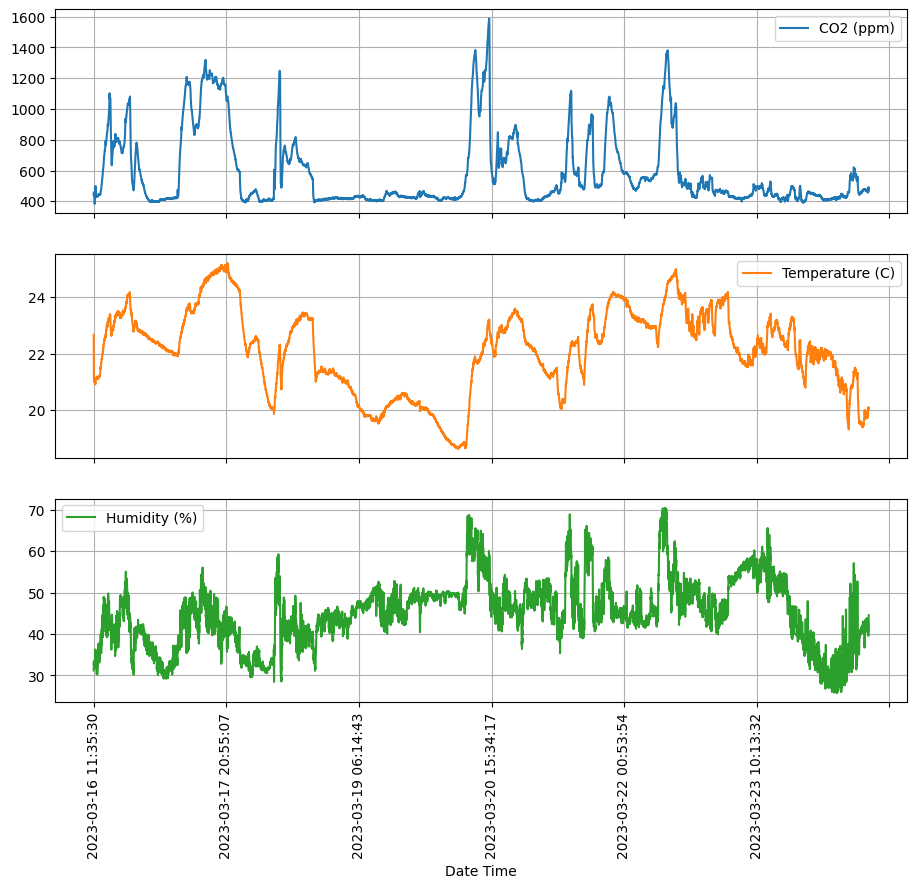

In [5]:
df.plot(figsize=(11, 9), subplots=True, grid=True)
plt.xticks(rotation=90);

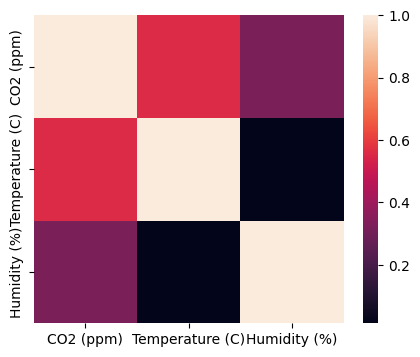

In [6]:
# columns correlation
plt.figure(figsize=(5,4))
sns.heatmap(df.corr().abs());

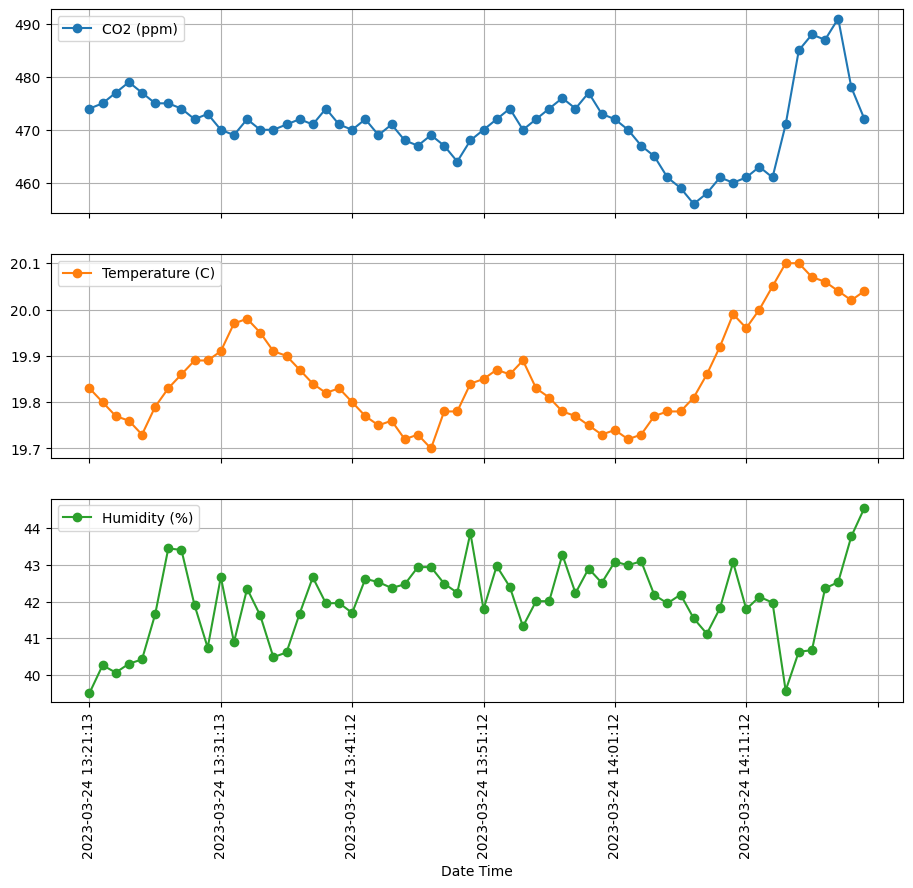

In [7]:
# change in last one hour
df[-60:].plot(figsize=(11, 9), subplots=True, marker='o', linestyle='-', grid=True)
plt.xticks(rotation=90);

# Data preprocessing

In [8]:
# drop the variables into the same range for the model works well
scaler = MinMaxScaler()
ts = pd.DataFrame(scaler.fit_transform(df.values), index=df.index, columns=df.columns)

In [9]:
# labeling data
X, y = SlidingWindow(1, horizon=1)(ts)

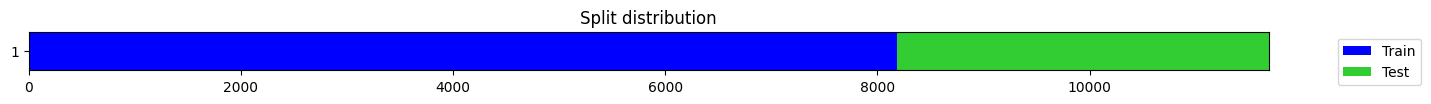

In [10]:
# split to train and test
test_size = round(df.shape[0]*0.3)

splits = TimeSplitter(test_size)(y) 
tfms = [None, TSForecasting()]
batch_tfms = TSStandardize()

# Model building

In [11]:
# build TSRegressor model and compile
reg = TSRegressor(X, y, splits=splits, path='models', tfms=tfms, batch_tfms=batch_tfms,
                        bs=64, arch="TSTPlus", metrics=mae, cbs=ShowGraph())

epoch,train_loss,valid_loss,mae,time
0,0.158212,0.147199,0.356464,00:04
1,0.127404,0.114302,0.308782,00:04
2,0.087800,0.074414,0.252148,00:04
3,0.033050,0.009827,0.083234,00:04
4,0.005427,0.001959,0.029589,00:04
5,0.002323,0.002183,0.036265,00:04
6,0.002023,0.000916,0.021595,00:04
7,0.001798,0.000565,0.014224,00:04
8,0.001898,0.000997,0.024296,00:04
9,0.002261,0.000630,0.015617,00:04


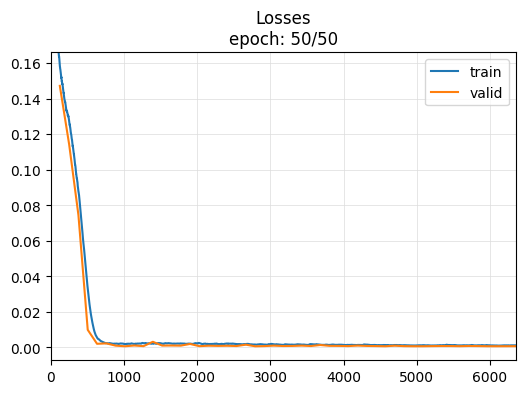

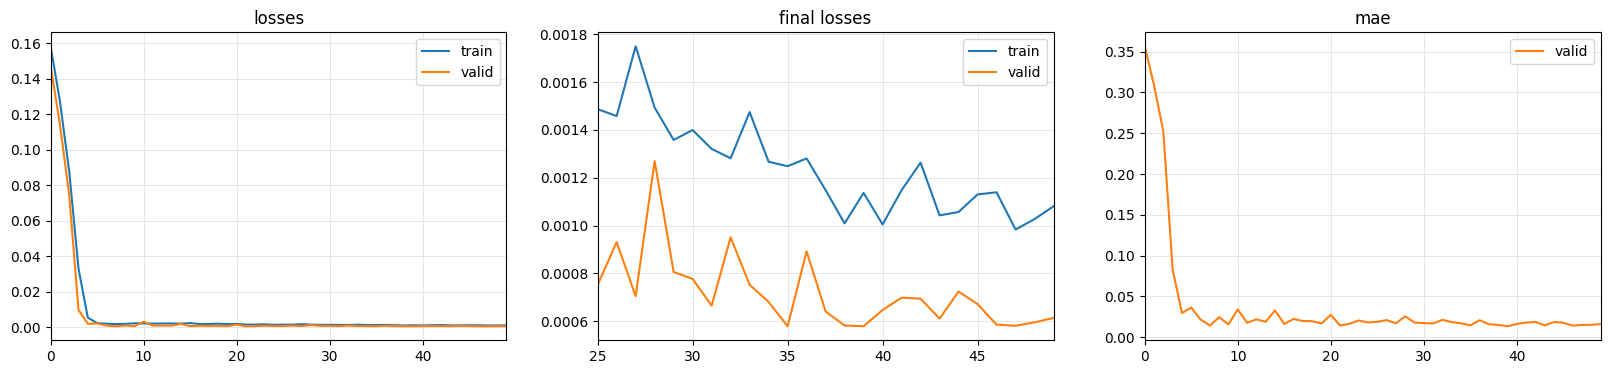

In [12]:
# model fitting
reg.fit_one_cycle(50, 1e-3)

In [13]:
# save model
reg.export("tsai.pkl")

In [14]:
# prediction
raw_preds, target, preds = reg.get_X_preds(X[splits[1]], y[splits[1]])
raw_preds.shape

torch.Size([3506, 3])

In [15]:
# MinMaxScaler inverse transform
pred = scaler.inverse_transform(raw_preds.numpy())
y_test = scaler.inverse_transform(y[splits[1]])

# Evaluation

In [16]:
print('Mean absolute error:',mean_absolute_error(y_test, pred))
print('Mean squared error:',mean_squared_error(y_test, pred))
print('Root mean squared error:',mean_squared_error(y_test, pred)**(1/2))

Mean absolute error: 5.1948273517052295
Mean squared error: 76.66306850121593
Root mean squared error: 8.755744885571755


In [17]:
print('Coefficient of determination (r2 score):',r2_score(y_test, pred))

Coefficient of determination (r2 score): 0.9837125171566826


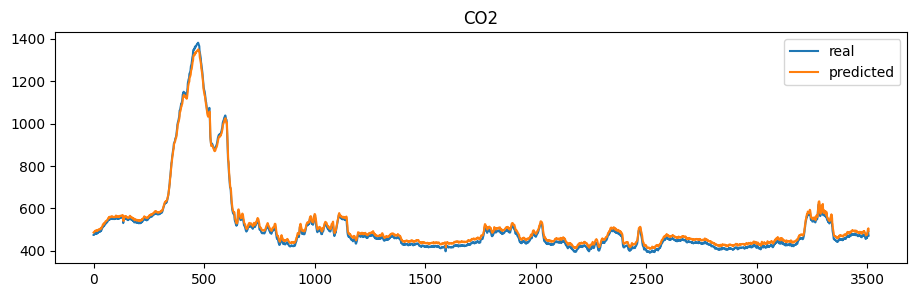

In [18]:
plt.figure(figsize=(11,3))
plt.plot(y_test[:,0])
plt.plot(pred[:,0])
plt.title('CO2')
plt.legend(['real', 'predicted'], loc='upper right')
plt.show()

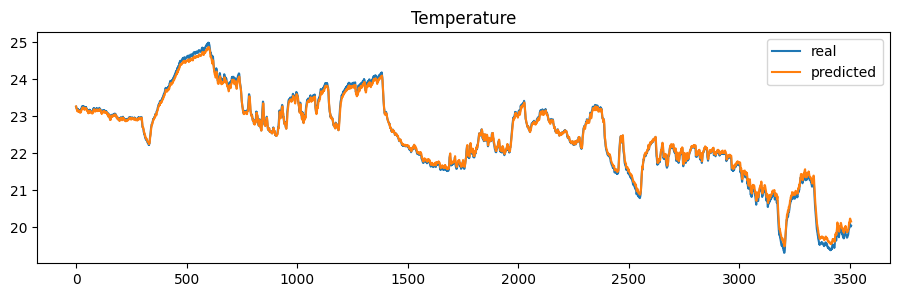

In [19]:
plt.figure(figsize=(11,3))
plt.plot(y_test[:,1])
plt.plot(pred[:,1])
plt.title('Temperature')
plt.legend(['real', 'predicted'], loc='upper right')
plt.show()

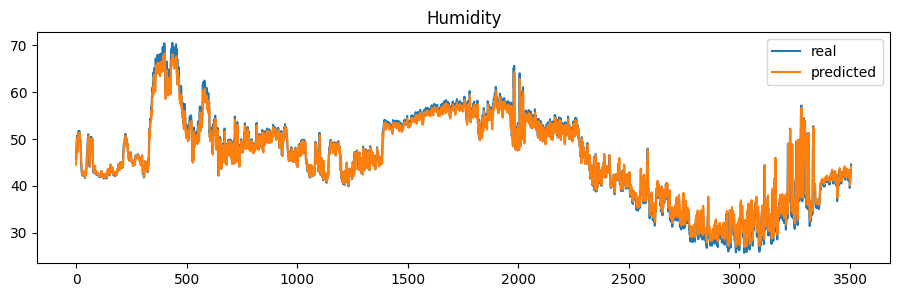

In [20]:
plt.figure(figsize=(11,3))
plt.plot(y_test[:,2])
plt.plot(pred[:,2])
plt.title('Humidity')
plt.legend(['real', 'predicted'], loc='upper right')
plt.show()